In [1]:
!pip install transformers -q
!pip install sentencepiece -q

     |████████████████████████████████| 2.9 MB 5.4 MB/s 
     |████████████████████████████████| 895 kB 45.8 MB/s 
     |████████████████████████████████| 3.3 MB 30.2 MB/s 
     |████████████████████████████████| 636 kB 39.7 MB/s 
     |████████████████████████████████| 56 kB 4.7 MB/s 
     |████████████████████████████████| 109 kB 46.6 MB/s 
     |████████████████████████████████| 546 kB 44.9 MB/s 
     |████████████████████████████████| 1.2 MB 5.4 MB/s 


In [2]:
import pandas as pd

import sys
# For running via Colab
sys.path.append('/content/drive/MyDrive/Colab Notebooks')
from bert_finetuner import *

In [3]:
data = pd.read_json('/content/drive/MyDrive/song_lyric_map.json')
#data = pd.read_json('https://raw.githubusercontent.com/pradeep-miriyala/multi-modal-bert-models/main/data/song_lyric_map.json?token=ADXRNFRS46PTRG46WUZLXHDBKH7HY')

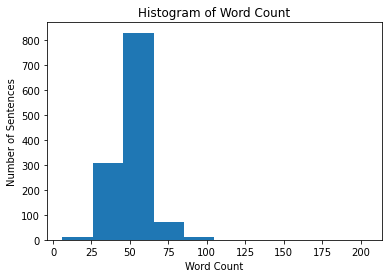

In [4]:
plot_histogram(data['Lyric'])

##### From the histogram, it is evident that most of the sentences have 50 words and some have 75. Although there are sentences with 100 words, the perecentage is very minimal. Hence maximum sequence length is considered as 75.

In [5]:
MAX_SEQ_LEN = 75
gpu, cpu = get_devices()

In [6]:
chk_point = 'ai4bharat/indic-bert'
base_model, tokenizer = load_bert_model(chk_point)

Downloading:   0%|          | 0.00/507 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/129M [00:00<?, ?B/s]

Some weights of the model checkpoint at ai4bharat/indic-bert were not used when initializing AlbertModel: ['predictions.decoder.bias', 'predictions.LayerNorm.weight', 'sop_classifier.classifier.weight', 'predictions.LayerNorm.bias', 'predictions.decoder.weight', 'predictions.dense.weight', 'sop_classifier.classifier.bias', 'predictions.bias', 'predictions.dense.bias']
- This IS expected if you are initializing AlbertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing AlbertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Downloading:   0%|          | 0.00/5.38M [00:00<?, ?B/s]

In [7]:
sequences, attention_masks, targets = process_data_w_base_model(data, tokenizer, max_seq_len=MAX_SEQ_LEN)

In [8]:
txt_results = k_fold_model_preparation(base_model, gpu, data, sequences, attention_masks, targets, fusion=False,
                                       k_folds=2, epochs=15, balance_classes=True, dropout_level=0.25, lr=2e-4,
                                       max_seq_len=MAX_SEQ_LEN, n_layers=3, clip_at=1.0)

Running Text Only Classification
FOLD 0
--------------------------------
Class Weights : [1.55555556 0.73684211]
Epoch 1 / 15
Training Model
Evaluating
Losses - Train : 0.690 / Validation : 0.665
Epoch 2 / 15
Training Model


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:154: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Evaluating
Losses - Train : 0.619 / Validation : 0.586
Epoch 3 / 15
Training Model
Evaluating
Losses - Train : 0.540 / Validation : 0.534
Epoch 4 / 15
Training Model
Evaluating
Losses - Train : 0.477 / Validation : 0.532
Epoch 5 / 15
Training Model
Evaluating
Losses - Train : 0.448 / Validation : 0.582
Epoch 6 / 15
Training Model
Evaluating
Losses - Train : 0.420 / Validation : 0.711
Epoch 7 / 15
Training Model
Evaluating
Losses - Train : 0.400 / Validation : 0.631
Epoch 8 / 15
Training Model
Evaluating
Losses - Train : 0.298 / Validation : 0.779
Epoch 9 / 15
Training Model
Evaluating
Losses - Train : 0.259 / Validation : 0.841
Epoch 10 / 15
Training Model
Evaluating
Losses - Train : 0.198 / Validation : 1.053
Epoch 11 / 15
Training Model
Evaluating
Losses - Train : 0.193 / Validation : 1.035
Epoch 12 / 15
Training Model
Evaluating
Losses - Train : 0.092 / Validation : 1.476
Epoch 13 / 15
Training Model
Evaluating
Losses - Train : 0.063 / Validation : 1.923
Epoch 14 / 15
Training Model

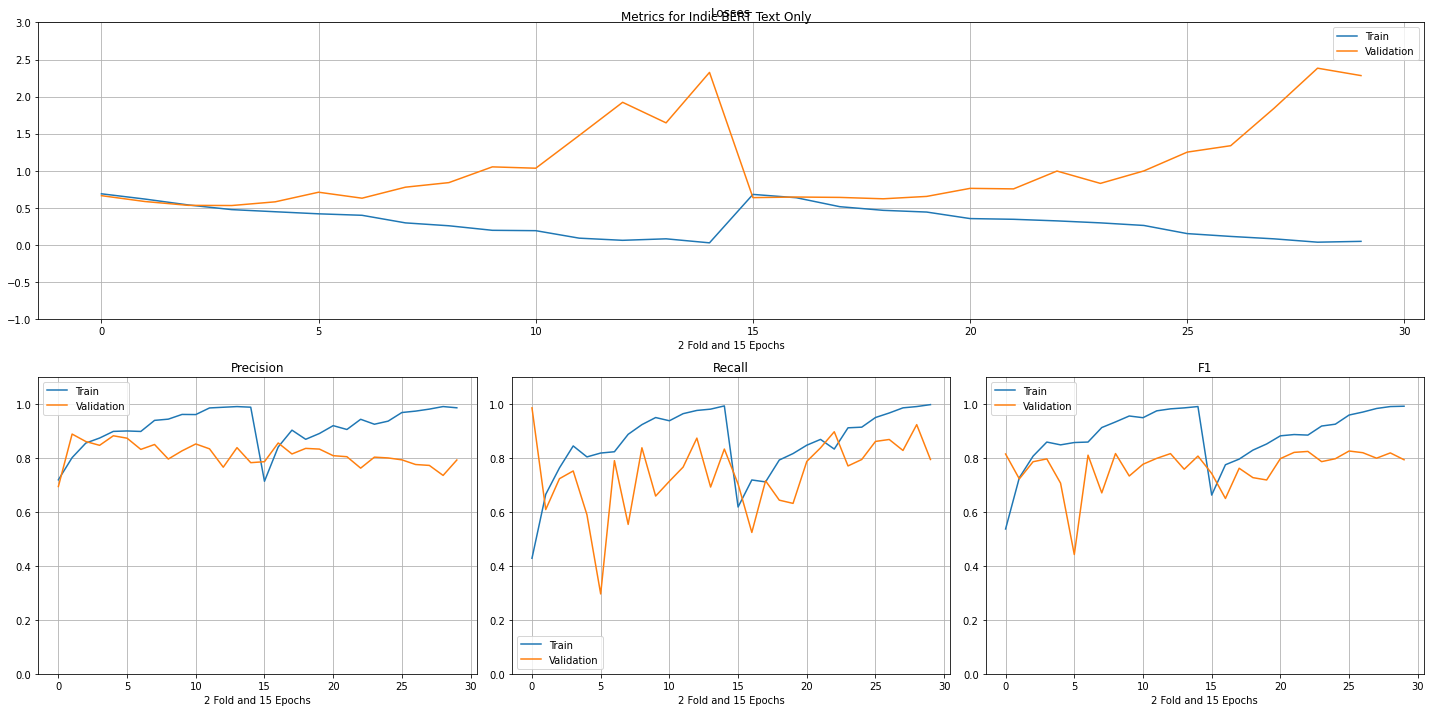

In [9]:
plot_results(txt_results, 'Indic BERT Text Only')

In [10]:
fusion_results = k_fold_model_preparation(base_model, gpu, data, sequences, attention_masks, targets, fusion=True,
                                       k_folds=2, epochs=15, balance_classes=True, dropout_level=0.25, lr=2e-4,
                                       max_seq_len=MAX_SEQ_LEN, n_layers=3, clip_at=1.0)

Running Fusion Model
FOLD 0
--------------------------------
Class Weights : [1.55555556 0.73684211]
Epoch 1 / 15
Training Model
Evaluating
Losses - Train : 0.691 / Validation : 0.691
Epoch 2 / 15
Training Model


/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:154: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)


Evaluating
Losses - Train : 0.688 / Validation : 0.675
Epoch 3 / 15
Training Model
Evaluating
Losses - Train : 0.660 / Validation : 0.615
Epoch 4 / 15
Training Model
Evaluating
Losses - Train : 0.624 / Validation : 0.613
Epoch 5 / 15
Training Model
Evaluating
Losses - Train : 0.646 / Validation : 0.613
Epoch 6 / 15
Training Model
Evaluating
Losses - Train : 0.648 / Validation : 0.620
Epoch 7 / 15
Training Model
Evaluating
Losses - Train : 0.602 / Validation : 0.595
Epoch 8 / 15
Training Model
Evaluating
Losses - Train : 0.614 / Validation : 0.608
Epoch 9 / 15
Training Model
Evaluating
Losses - Train : 0.569 / Validation : 0.619
Epoch 10 / 15
Training Model
Evaluating
Losses - Train : 0.575 / Validation : 0.553
Epoch 11 / 15
Training Model
Evaluating
Losses - Train : 0.560 / Validation : 0.565
Epoch 12 / 15
Training Model
Evaluating
Losses - Train : 0.525 / Validation : 0.563
Epoch 13 / 15
Training Model
Evaluating
Losses - Train : 0.477 / Validation : 0.547
Epoch 14 / 15
Training Model

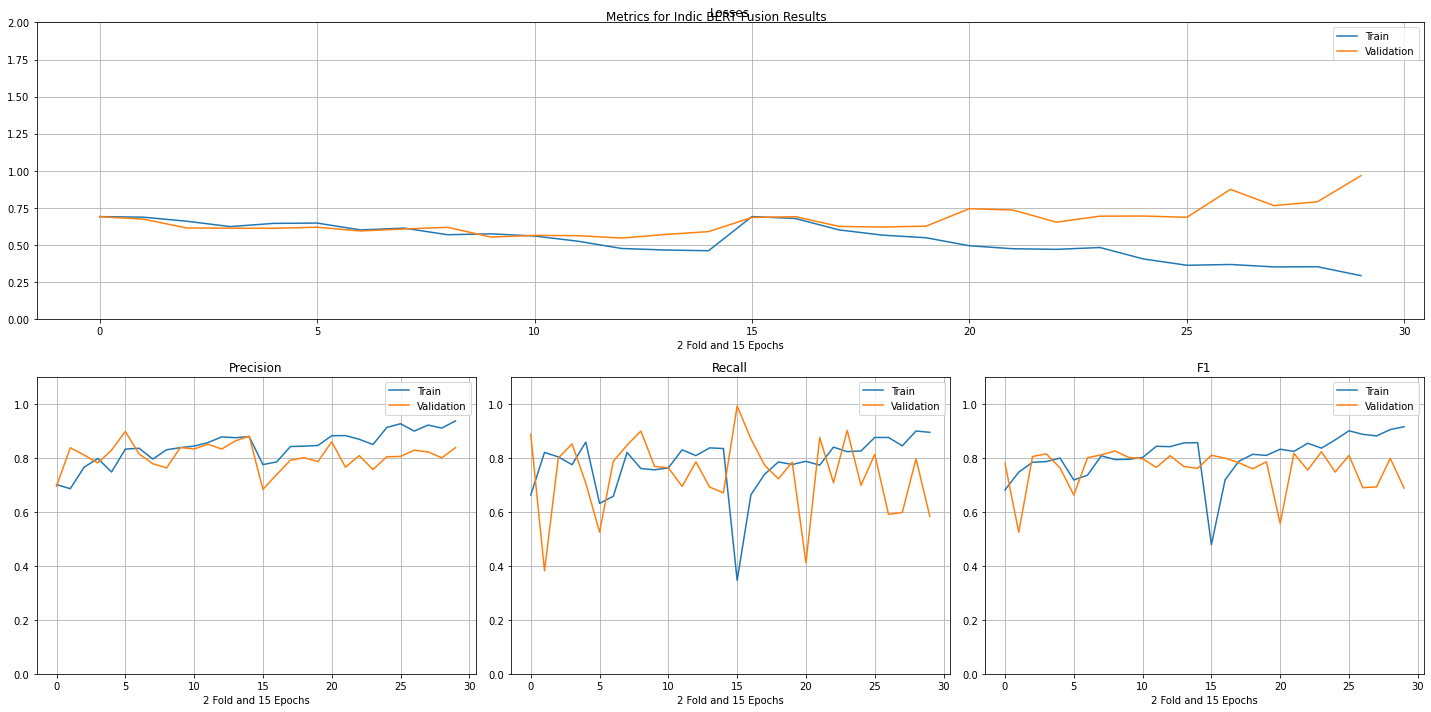

In [11]:
plot_results(fusion_results,'Indic BERT Fusion Results')